In [71]:
# this is copy of idfglove.ipynb
# do it again, but build a model out of the uncased 
# file glove.42B.300d.txt
# using the Glove vocab

# standard library
import time
import json
import re
import numpy as np
import urllib

import sentence_transformers
from sentence_transformers.models.tokenizer import WhitespaceTokenizer
from sentence_transformers.models import WordEmbeddings

from scipy.linalg import norm
from math import log

import matplotlib.pyplot as plt

# Read in data

In [2]:
# dirname = "/Users/cschmidt/delomore/delomore-parse-output/output/"

In [3]:
# alljson = { "collections" : {},
#             "products" : {},
#             "homepage" : [],
#             "about" : [],
#             "pages" : [],
#             "blogs" : [],
#           }

In [4]:
# queryfile = "/Users/cschmidt/otherrepos/delomore-dataset/query-domains.tsv"
# querydomain = open(queryfile, "rt").readlines()
# querydomain = [l.rstrip().split("\t") for l in querydomain]

# # get the set of display domains
# gooddomains = set()

# for (query, displaydomain, domain) in querydomain:
#     gooddomains.add(displaydomain)
    
# print(len(gooddomains))

# Get the vocab from the Glove model directly

In [5]:
# this is the model that doesn't consider case of words
# get everything up to the first space
def getinitialword(s):
    return s[:s.find(" ")]

glovefile = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.txt"

start_time = time.time()
vocab = [getinitialword(l) for l in open(glovefile, 'rt').readlines()]

vocabSet = set(vocab)
print(len(vocab))

# no dupes this time
print(len(vocabSet))

print("time:", time.time() - start_time)

1917494
1917494
time: 32.60562610626221


In [6]:
# filter out some of the words with a . in them,
# including a bunch of number related cruft 

# lets include things like 2,890.00
isnumber = re.compile("^[0-9.,:-]+$")
justdigits = re.compile("^[0-9]+$")

def isNumber(s):
    return isnumber.search(s) != None

def isInteger(s):
    return justdigits.search(s) != None

In [7]:
# how many cases have a period just at the end
# and the word without it is in the vocab
def isbad(s):
    firstdot = s.find(".")
    # no dot
    if firstdot == -1:
        return False
    # first dot isn't last character
    if firstdot != len(s)-1:
        return False
    # is bad if the word without it is in vocab
    return s[:firstdot] in vocab

badwords = set()
integers = set()
numbers = set()
otherdot = set()
for v in vocab:
        
        if isNumber(v):
            
            # lets keep the integers
            if isInteger(v):
                integers.add(v)
            else:
                # but lose the crufty numbers
                numbers.add(v)
        else:
            
            if isbad(v):
                badwords.add(v)
            else:
                if "." in v:
                    otherdot.add(v)
print("bad:",len(badwords))
print("integers:",len(integers))
print("numbers:",len(numbers))
print("other:",len(otherdot))

bad: 4962
integers: 65814
numbers: 255305
other: 74555


In [9]:
list(integers)[:10]

['13642',
 '14458',
 '53549',
 '54971',
 '26380',
 '63032',
 '6670',
 '32571',
 '10338',
 '1015213']

In [10]:
list(numbers)[:10]

['23:16:54',
 '00:15:33',
 ':18.8',
 '06:28:31',
 '17:54:58',
 '19,052',
 '106-07',
 '46-47',
 '7.36',
 '19:45:17']

In [11]:
# keep these
list(otherdot)[:10]

['infoplist.strings',
 'j.w.m.',
 'weeks.â',
 'yahoo.it',
 'accounts.i',
 'freedentalguide.com',
 'xxx.xxx.xxx.xxx',
 'lww4.htm',
 'moron.nl',
 'basement.org']

In [12]:
toskip = badwords | numbers
print(len(toskip))

260267


In [13]:
print("piece." in toskip)
print("quality." in toskip)
print("interior." in toskip) 

True
True
True


In [15]:
glovefilefiltered = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.filtered.txt"

# filter out the vectors for the words in toskip
kept = 0
filtered = 0

start_time = time.time()
with open(glovefilefiltered, "wt") as out:
    for l in open(glovefile, 'rt'):
        v = getinitialword(l)
        if v not in toskip:
            kept += 1 
            out.write(l)
        else:
            filtered += 1
            
print("time:", kept, filtered, time.time() - start_time)

time: 1657227 260267 10.859287023544312


In [16]:
# Load in the filtered text file, and make a tokenizer
# covert to the right internal format
# these embeddings are all lower case, so 
# have the tokenizer convert to lower case
model = WordEmbeddings.from_text_file(glovefilefiltered,tokenizer=WhitespaceTokenizer(do_lower_case=True))

Load Word Embeddings: 1657227Embeddings [02:21, 11677.17Embeddings/s]


In [17]:
# and dump it to disk
savedmodel = "/Users/cschmidt/otherrepos/idf-glove/glove/weightedoutput42"
model.save(savedmodel)

In [18]:
# redo vocab with filtering
start_time = time.time()
vocab = [getinitialword(l) for l in open(glovefilefiltered, 'rt').readlines()]

vocabSet = set(vocab)
print(len(vocab))
print(len(vocabSet))

print("time:", vocab, vocabSet, time.time() - start_time)

1657227
1657227
time: 18.87205195426941


# Get our Glove vocabulary

In [19]:
# augment this with our padding token that is in the tokenizer
tokenvocab = ["PADDING_TOKEN"] + vocab

In [20]:
# given the index in vocab, give us the words back
idx2word = { idx: w for (idx,w) in enumerate(tokenvocab) }
print(len(idx2word))

1657228


In [21]:
# can load it in directly
# note that it ignores stopwords
tokenizer = WhitespaceTokenizer().load(savedmodel)

In [22]:
# tokenize with our WhitespaceTokenizer, 
# but then return the actual words in a list
def tokenizeWords(s):
    return [idx2word[idx] for idx in tokenizer.tokenize(s)]

In [23]:
words = tokenizeWords("cow white")
print(words)
# stop words dissappear
words = tokenizeWords("the cow is white")
print(words)
# converts to lower case, drops punctuation
words = tokenizeWords("the Cow is white!")
print(words)

['cow', 'white']
['cow', 'white']
['cow', 'white']


In [27]:
# you do end up with some . characters in the vocab
# now have filtered some of these out
tokenizeWords("50 beanie package. a.m. 7.36")

['50', 'beanie', 'package', 'a.m.']

In [28]:
tokenizeWords("8.5")

[]

In [26]:
# compute our idf term, 
# for just those words in the vocabSet
# add 1 so still works if no values ??
# idf = { w : np.log(N/c) for (w,c) in wikidf.items() if w in vocabSet}
# len(idf)

In [29]:
# save clean to a file so we can compute information gain

# note that collections just have an 'og:title' and 'product-handles'

# output a single line, with space separated unique words
# skip if no words (that are in the vocab)
def getTokenizedText(d, out, row):
    
    text = ""
    
    for field in ["og:title", "og:site_name", "og:description"]:
        if field in d:

            # is occasionally a list, just use first then 
            if type(d[field]) == list:
                text += d[field][0] + " "
            else:
                text += d[field] + " "
    
    # eliminate duplicates, ends up in arbitrary order
    words = list(set(tokenizeWords(text)))
    
    # we want to generate pairs, so ignore ones with a single word
    if len(words) > 1:
        # space separate the words
        words = " ".join(words)
        # tab between row and words
        # out.write(str(row) + "\t" + text + "\n")
        out.write(str(row) + "\t" + words + "\n")
        # success so advance to next row
        return row + 1
    else:
        return row
    
start_time = time.time()

# directory for input data
dirname = "/Users/cschmidt/delomore/delomore-parse-output/output/"
row = 0

# just save in this repo
out = open("cleanwords.filtered.tsv", "wt")

# Use each page as a document here
# 00000 to 14222
for chunk in range(14223):
    
    if chunk % 100 == 0:
        print(chunk, time.time() - start_time)
    
    chunkname = str(chunk).rjust(5, '0') + ".tsv"

    filename = dirname + chunkname
    data = [l.rstrip().split("\t") for l in open(filename, 'rt').readlines()]    

    for domain,displaydomain,url,alljson in data:

        # convert to json
        j = json.loads(alljson)

        # are 4 possible kinds of pages to use
        if "about" in j:
            # is a possibly empty list
            for d in j["about"]:
                row = getTokenizedText(d, out, row)

        # note that collections just have an 'og:title' and 'product-handles'
        if "collections" in j:
            # is a dict with handles
            for handle, d in j["collections"].items():
                row = getTokenizedText(d, out, row)

        # has handles
        if "products" in j:
            # is a dict with handles
            for handle, d in j["products"].items():
                row = getTokenizedText(d, out, row)

        # has handles
        if "homepage" in j:
            # is a possibly empty list
            for d in j["homepage"]:
                row = getTokenizedText(d, out, row)

out.close()

0 0.0027091503143310547
100 20.430618047714233
200 41.83625411987305
300 60.65954113006592
400 82.61731910705566
500 104.86676716804504
600 127.89059615135193
700 148.06602907180786
800 170.23068809509277
900 190.79873204231262
1000 209.79683804512024
1100 228.79774403572083
1200 247.48914408683777
1300 266.4047701358795
1400 286.63281416893005
1500 308.7200610637665
1600 328.9879729747772
1700 349.9434971809387
1800 370.57430624961853
1900 390.8628239631653
2000 411.28292417526245
2100 433.6215569972992
2200 453.4350321292877
2300 473.76387906074524
2400 493.9031460285187
2500 514.5479071140289
2600 535.0809600353241
2700 555.1044640541077
2800 575.500785112381
2900 597.0536060333252
3000 617.7861762046814
3100 637.6052160263062
3200 657.8709189891815
3300 679.0987811088562
3400 700.4131379127502
3500 721.0105049610138
3600 740.8786859512329
3700 761.38858294487
3800 781.3772020339966
3900 800.529176235199
4000 821.0987939834595
4100 842.0032362937927
4200 863.7337129116058
4300 886.2

# Use the values for Information Gain

In [184]:
import pandas as pd
igdf = pd.read_csv("/Users/cschmidt/otherrepos/idf-glove/e73f3955-ae36-4e87-bf0e-e3bafb16b66e.csv")
print(len(igdf))
igdf = igdf[igdf["df"] > 1.0]
print(len(igdf))

igvocab = igdf["y"].values
ig = igdf["ig"].values
logig = [log(gain) for gain in ig]
df = igdf["df"].values

# huh, a bunch must be in a single page
print(len(igvocab))

851216
851216
851216


In [185]:
print(min(df),max(df))

2.0 6995638.0


In [186]:
# total number of documents is much bigger
N = 62551463

In [187]:
igdf.head()

,y,ig,df
0,increased,69.746048,110100.0
1,pin,11.840057,314004.0
2,personalization,32.981563,46536.0
3,year,23.926281,788657.0
4,traditional,19.854489,714412.0


In [193]:
# do in forward sorted order
# and include regular ig
logtriples = sorted(zip(logig,igvocab,df))
print(len(logtriples))

851216


In [194]:
triples = sorted(zip(ig,igvocab,df))
print(len(triples))

851216


In [195]:
[(gain,w,df) for (gain,w,df) in triples if df > 2000000]

[(1.8915581190668933, 'shop', 3555773.0),
 (5.857663604233599, 'online', 2027319.0),
 (5.954190439095553, 'store', 2457484.0),
 (6.199797206673628, 'black', 4732740.0),
 (6.794406939206565, 'blue', 2481810.0),
 (7.516448653709461, 'white', 3792385.0),
 (8.653661285005734, 'collection', 2499731.0),
 (9.390529106362967, 'set', 3205157.0),
 (10.73833539564858, 'x', 5424650.0),
 (10.855846555205725, 'available', 3613522.0),
 (11.207640801077588, 'new', 3820343.0),
 (11.276468302607132, 'classic', 2181285.0),
 (11.305417997477967, 'size', 6995638.0),
 (11.42372416742235, 'perfect', 5133013.0),
 (11.622765523514946, 'style', 3781796.0),
 (12.351495103556408, 'long', 2598445.0),
 (12.550034230513283, 'gold', 2982774.0),
 (12.557572356512685, '100', 5330145.0),
 (12.585423550474037, 'great', 2912332.0),
 (12.604722560308964, 'free', 3503298.0),
 (12.622098000289888, 'love', 2353170.0),
 (12.849627422065138, 'beautiful', 2295289.0),
 (12.875548350658825, 'silver', 2314650.0),
 (13.0450341895756

In [196]:
logiglookup = { w : gain for (w,gain) in zip(igvocab,logig)}
iglookup = { w : gain for (w,gain) in zip(igvocab,ig)}

In [197]:
print(logiglookup["weighted"])
print(logiglookup["blanket"])

print(iglookup["weighted"])
print(iglookup["blanket"])

3.418185042833588
3.2531189656544583
30.513983160627262
25.870904675658107


In [198]:
test = [
    "american",
"aprons",
"bags",
"blanket",
"blankets",
"board",
"british",
"camera",
"chef",
"chocolate",
"cloth",
"facemask",
"fashion",
"fun",
"games",
"handbags",
"hoodies",
"knitwear",
"leather",
"luxury",
"mattresses",
"men",
"metal",
"native",
"notebooks",
"pajamas",
"pens",
"pottery",
"shaving",
"shoes",
"tea",
"teen",
"weighted",
"red",
"m",
"xl", 
"chicago"
]
for w in test:
    print(w, logiglookup.get(w,-1), iglookup.get(w,-1))

american 2.8887366842262323 17.97059272202579
aprons 3.4533988647954175 31.60764004023112
bags 2.7823054882790994 16.15622603335825
blanket 3.2531189656544583 25.870904675658107
blankets 3.543992155079039 34.60479149807041
board 2.9743915367492915 19.5777073093269
british 3.1242696502284257 22.7432784780534
camera 3.770159239602663 43.38697321016838
chef 3.3739220740959737 29.192799140823837
chocolate 3.193168826129651 24.36551532115929
cloth 3.324166425557202 27.775835763199147
facemask 3.668374845894987 39.18816727090962
fashion 2.368893531285178 10.685562500068388
fun 2.6457828157435945 14.09447414195676
games 3.302162731575643 27.17133973512245
handbags 3.2361314782411217 25.43513480500244
hoodies 3.349830903748783 28.49791434583277
knitwear 3.3367490316554473 28.127536177398795
leather 2.7556978062575554 15.732014971962617
luxury 2.7084351498406516 15.005775342610727
mattresses 3.8126433702352864 45.26994607383858
men 2.922390688068383 18.58566692203768
metal 2.67187575478638 14.4

In [199]:
triples[:20]

[(1.8368439952115456, 'whink', 1969.0),
 (1.8915581190668933, 'shop', 3555773.0),
 (2.3066991024224075, 'clytaemnestra', 3.0),
 (2.6827412815699008, 'feaured', 2.0),
 (2.8029945171530986, 'icdi', 4.0),
 (2.805790596860934, 'diamondstar', 2.0),
 (2.8257714902992896, 'steeling', 1257.0),
 (3.536365522991127, 'mascorro', 334.0),
 (3.640725375507359, 'stylefinder', 2345.0),
 (4.456467825523223, 'st.giles', 8.0),
 (4.492109895325976, 'grubi', 2.0),
 (4.519468669157711, 'bayb', 167.0),
 (4.5505621786975405, 'boutique', 1793463.0),
 (4.571293183829903, 'pregno', 2.0),
 (4.6345168496611855, 'cronian', 2.0),
 (4.698973137186169, 'moonshake', 885.0),
 (4.839672514173161, 're-fashion', 3972.0),
 (4.939348414212057, 'turbon', 277.0),
 (4.965756391244324, 'transmode', 2.0),
 (4.974307611188786, 'iart', 507.0)]

In [200]:
triples[-40:]

[(17142.731339203412, 'austill', 2.0),
 (17193.544057183593, 'sharick', 2.0),
 (17274.129722577636, 'radloff', 2.0),
 (17430.764777935103, 'stenerson', 2.0),
 (17598.51709329118, 'mcclarren', 2.0),
 (17659.263080277415, 'rierson', 2.0),
 (17681.458676256254, 'guwange', 7.0),
 (17722.13286420623, 'cartter', 2.0),
 (17895.271097170003, 'gitchell', 2.0),
 (17957.401014982086, 'tollerson', 2.0),
 (17981.66434800285, 'evenes', 2.0),
 (17981.664348002854, 'hineman', 2.0),
 (18000.410495586373, 'toukon', 7.0),
 (18000.41049558641, 'xess', 7.0),
 (18115.077081666783, 'stwart', 2.0),
 (18197.41032645542, 'stogsdill', 3.0),
 (18261.771569366123, 'matkins', 2.0),
 (18265.20343218498, 'harns', 2.0),
 (18369.56161451598, 'kepley', 2.0),
 (18476.50603691817, 'zeimer', 2.0),
 (18698.72481398337, 'leighty', 2.0),
 (18974.326714999843, 'hauth', 2.0),
 (19127.69301134572, 'tallett', 2.0),
 (19214.33375745006, 'iinkai', 5.0),
 (19410.493665758186, 'goehler', 2.0),
 (19681.93375476692, 'rickerson', 3.0),


In [201]:
sortedig = sorted(ig)

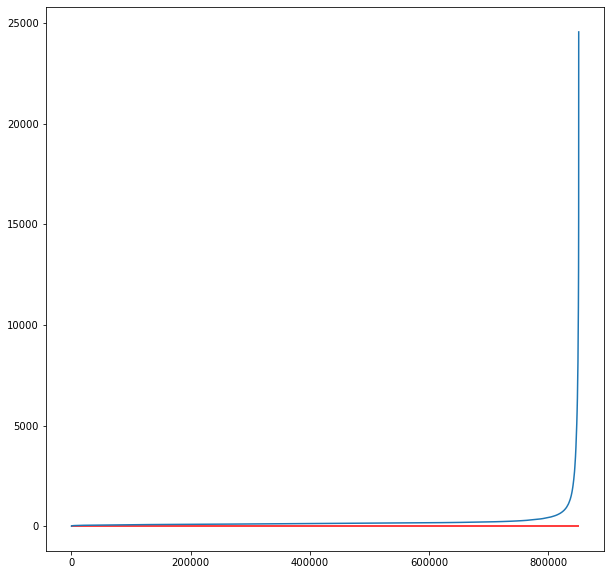

In [202]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(sortedig)
plt.hlines(y=0,xmin=0, xmax=len(ig), color="red")

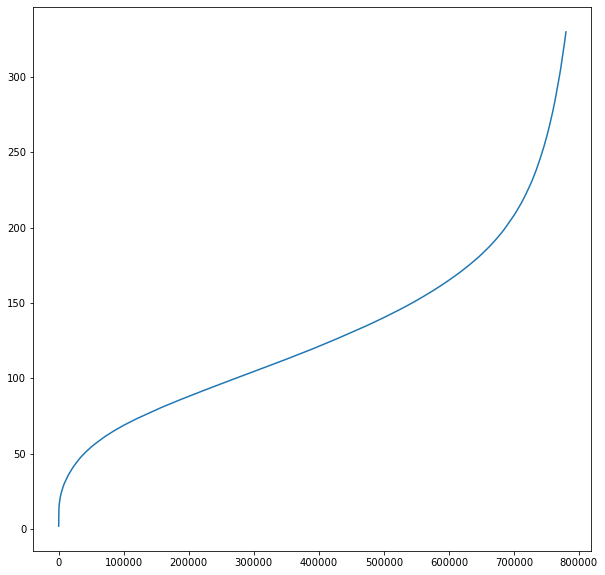

In [203]:
# lets see how it looks before zooming off
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(sortedig[:780000])

In [204]:
# it has a nice linear region, so lets extend that out to cut off the larger values
# what is our slope around 200000
# delta y / delta x
slope = (sortedig[201000] - sortedig[200000])/(201000 - 200000)

print(slope)
intercept = sortedig[200000]
print(intercept)

0.00016788661638730674
87.97497530361497


In [209]:
# now make a series that is linear from 200000 on 
linear = []
quad = []
linlookup = {}
for i, (gain,w,df) in enumerate(triples):
    if i <= 200000:
        lin = gain
    else:
        # linear approximation
        lin = intercept + slope*(i-200000)
    
    linear.append(lin)
    quad.append((gain,w,df,lin))
    linlookup[w] = lin
print(len(linear))

851216


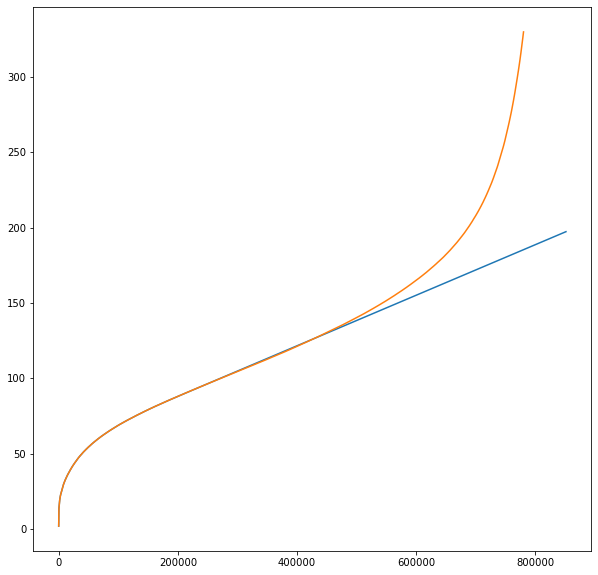

In [207]:
# did we do that right?
sortedig = sorted(ig)
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(linear)
plt.plot(sortedig[:780000])

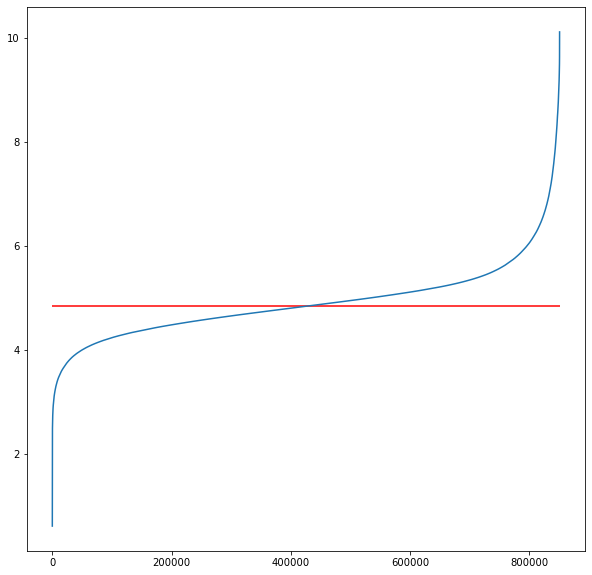

In [208]:
# log information gain looks nice too
# lets weight based on this
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(sorted(logig))
plt.hlines(y=np.median(logig),xmin=0, xmax=len(ig), color="red")

In [ ]:
# wc cleanwords.tsv
# 62,587,173 1,658,580,366 11711434739 cleanwords.tsv

In [214]:
# now update our filtered vectors file, 
# only keeping those rows in logiglookup,
# and multiplying each row by the logig value

glovefile =   "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.filtered.txt"
# weightedout = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.logig.txt"
weightedout = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.42B.300d.iglinear.txt"

# get everything up to the first space
def getinitialword(s):
    return s[:s.find(" ")]

out = open(weightedout, "wt")

written = 0
skipped = 0

start_time = time.time()
for line in open(glovefile, 'rt'):
    # this will be a bit faster, since most won't be in idf3
    gw = getinitialword(line)
    # only keep if have a valid weight
    if gw in logiglookup:
        vec = line.rstrip().split(" ")
        assert vec[0] == gw
        # drop the word
        vec = vec[1:]
        vec = np.array([float(x) for x in vec])
        # need to normalize
        vec /= norm(vec)
        # and multiply by logiglookup
        # vec *= logiglookup[gw]
        vec *= linlookup[gw]
        out.write(gw + " " + " ".join([str(a) for a in vec]) + "\n")
        written += 1
    else:
        skipped += 1
        
print("time:", written, skipped, time.time() - start_time)
out.close()

time: 851213 806014 318.9523992538452


In [211]:
print(logiglookup["weighted"])
print(logiglookup["blanket"])
print(linlookup["weighted"])
print(linlookup["blanket"])

3.418185042833588
3.2531189656544583
30.513983160627262
25.870904675658107


In [212]:
# just look at an example
test = ["bearaby",
"weighted",
"blanket",
"made",
"without",
"artificial",
"fillers",
"or",
"synthetic",
"fabrics",
"Naturally",
"heavy",
"cooling",
"and",
"hand-knit",
"with",
"organic",
"materials",
"Buy",
"weighted",
"blanket",
"now"]
        
for w in test:
    print(w, linlookup.get(w,0.0), logiglookup.get(w,0.0))

bearaby 0.0 0.0
weighted 30.513983160627262 3.418185042833588
blanket 25.870904675658107 3.2531189656544583
made 0.0 0.0
without 0.0 0.0
artificial 46.705330141896766 3.843858293962644
fillers 66.78556366463901 4.201486944382058
or 0.0 0.0
synthetic 28.840631056851432 3.361785193482884
fabrics 21.574233337369996 3.0714997015696346
Naturally 0.0 0.0
heavy 22.58045557995338 3.1170847347780923
cooling 47.40362649078554 3.8586987340188452
and 0.0 0.0
hand-knit 36.877763256114015 3.607608747611464
with 0.0 0.0
organic 22.427068359787377 3.110268638241677
materials 21.92332810213389 3.0875512800317972
Buy 0.0 0.0
weighted 30.513983160627262 3.418185042833588
blanket 25.870904675658107 3.2531189656544583
now 0.0 0.0


In [213]:
test = ["Protection",
"Baby",
"Blanket",
"Eighth",
"Generation",
"Native",
"American",
"designed",
"Wool",
"Baby",
"Blankets",
"by",
"Eighth",
"Generation",
"Wool",
"Blanket",
"design",
"features",
"Blackfeet",
"ledger",
"art",
"by",
"Native",
"American",
"artist",
"John",
"Isaiah",
"Pepion",
"Native",
"American",
"&",
"Indian",
"Wool",
"Blanket",
"fashion",
"for",
"Men",
"Women",
"&",
"Home",
"Shop",
"Quality",
"Native",
"American",
"made",
"Wool",
"Blankets",
"that",
"feature",
"authentic",
"Native",
"American",
"art"]

test = [
    "american",
"aprons",
"bags",
"blanket",
"blankets",
"board",
"british",
"camera",
"chef",
"chocolate",
"cloth",
"facemask",
"fashion",
"fun",
"games",
"handbags",
"hoodies",
"knitwear",
"leather",
"luxury",
"mattresses",
"men",
"metal",
"native",
"notebooks",
"pajamas",
"pens",
"pottery",
"shaving",
"shoes",
"tea",
"teen",
"weighted",
"red",
"m",
"xl", 
"chicago"
]

tosort = sorted([(linlookup.get(w,0.0),w) for w in test], reverse=True)

huh = []
for s,w in tosort:
    print(w, s, ranks.get(w, -1))
    huh.append(ranks.get(w, -1))
    
huh = sorted(huh)

mattresses 45.26994607383858 0.9652814326798368
camera 43.38697321016838 0.9692005319448882
xl 43.384782093344896 0.9692052311046785
shaving 41.62943502244528 0.9726743858198155
facemask 39.18816727090962 0.9770046615665119
notebooks 37.187888135852845 0.9802623540910885
teen 35.1562225029493 0.9834260634198605
blankets 34.60479149807041 0.9841708802466119
pajamas 32.630585555301195 0.986864673596361
aprons 31.60764004023112 0.9881240484201425
weighted 30.513983160627262 0.9893881224037142
pens 29.649915191425865 0.9903385274712881
chef 29.192799140823837 0.990795520760888
native 29.080995255446677 0.9909247476551193
hoodies 28.49791434583277 0.9914874720399992
knitwear 28.127536177398795 0.9918528317136895
cloth 27.775835763199147 0.992178248529163
games 27.17133973512245 0.9927339241743576
pottery 26.81419976140486 0.9930546418300408
blanket 25.870904675658107 0.9938335275652713
tea 25.59684756077231 0.9940297174865134
handbags 25.43513480500244 0.994153070431007
chocolate 24.3655153

In [215]:
# save things out to the right format on disk
# covert to the right internal format
model = WordEmbeddings.from_text_file(weightedout)

Load Word Embeddings: 851213Embeddings [02:12, 6420.47Embeddings/s]


In [216]:
# and dump it to disk
# model.save("/Users/cschmidt/otherrepos/idf-glove/glove/loginfogainoutput")
model.save("/Users/cschmidt/otherrepos/idf-glove/glove/infogainlinoutput")